# Baseball improvement

## Introduction
For this project, we will create a supervised machine learning that trains on the Lahman data set, the most significant baseball data set based on MLB metrics (available at http://www.seanlahman.com/). Based on their metrics, we want to predict if a player will likely improve offensively compared to their previous season. We will use the batting, people, and appearance tables for this assignment to create our predictions. We will then test different models and train our data database to compare our predictor with the actual data later. Lastly, we will create a usable algorithm that receives a player's name and year and predicts whether he will improve on that season.

## Imports

For this project, we will use the pandas library for our data sets, Numpy for calculations and conversions, Altair, Seaborn, and Matplot for visualization, and, lastly, Sklearn for our modeling and machine learning creation. Be sure to install the updated version of Altair so the code can run properly.

In [1]:
!pip install -U altair
import pandas as pd
import numpy as np
import altair as alt
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline
sns.set()
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder

# Creating the dataset
We will start our analyses by creating and cleaning our data set. We will use data from 2002 to 2022 and players who had played as hitters for at least 30 games. We will not include pitchers for this analysis since our metric is offensive. We combined our datasets and removed the columns not used in this analysis. We then create a new column called score that determines how well a player performs during the season. The score will be based on the point system described bellow: H = 1pt, 2B = 1.5pt, 3B = 2pt, RBI = 2.5pt, HR = 3 pt, SB = 0.5pt, BB = 1pt.

In [2]:
batting = pd.read_csv("Batting.csv")
people = pd.read_csv("People.csv")
Appearances = pd.read_csv("Appearances.csv")

In [3]:
batting2 = batting.merge(Appearances, left_on=['playerID', 'yearID', 'teamID','G'], right_on=['playerID', 'yearID','teamID','G_all'])

In [4]:
batting2 = batting2[batting2['yearID'] >= 2012.00]
batting2 = batting2[batting2['G_p'] == 0]
batting2 = batting2[batting2['G'] >= 30]
batting2 = batting2.drop(columns=["stint", "HBP", "IBB",'G_defense', 'G_p', 'G_c', 'G_1b', 'G_2b', 'G_3b', 'G_ss', 'G_lf',
       'G_cf', 'G_rf', 'G_of', 'G_dh', 'G_ph', 'G_pr'])

In [5]:
batting2.describe()

,yearID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,SH,SF,GIDP,G_all,GS,G_batting
count,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000
mean,2016.839048,93.689794,308.971763,41.253731,79.426583,15.799919,1.556071,10.622025,39.445744,5.003832,1.831384,29.004034,71.272892,1.015732,2.314240,6.763413,93.689794,79.984066,93.689794
std,3.180012,41.454552,170.205905,27.168208,49.188674,10.679775,1.959130,9.495714,27.479649,7.439310,2.347080,21.200513,40.468349,1.840348,2.179758,5.259102,41.454552,44.235956,41.454552
min,2012.000000,30.000000,27.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,30.000000,2.000000,30.000000
25%,2014.000000,54.000000,159.000000,18.000000,37.000000,7.000000,0.000000,3.000000,17.000000,0.000000,0.000000,13.000000,38.000000,0.000000,1.000000,3.000000,54.000000,41.000000,54.000000
50%,2017.000000,92.000000,282.000000,35.000000,69.000000,14.000000,1.000000,8.000000,33.000000,2.000000,1.000000,24.000000,63.000000,0.000000,2.000000,5.000000,92.000000,73.000000,92.000000
75%,2019.000000,132.000000,459.000000,60.000000,118.000000,23.000000,2.000000,15.000000,57.000000,6.000000,3.000000,40.000000,100.000000,1.000000,3.000000,10.000000,132.000000,119.000000,132.000000
max,2022.000000,162.000000,684.000000,137.000000,225.000000,56.000000,15.000000,62.000000,139.000000,64.000000,23.000000,145.000000,222.000000,17.000000,15.000000,31.000000,162.000000,162.000000,162.000000


In [6]:
df = batting2.loc[:, ['playerID', 'yearID','teamID','G_batting']]
df['score'] = (batting2['H']+batting2['2B']*1.5+batting2['3B']*2+batting2['RBI']*2.5+batting2['HR']*3+batting2['SB']*0.5+batting2['BB']-batting2['CS']*0.25)/batting2['G_batting']
df.sort_values(by=['playerID', 'yearID'], inplace=True)
df['yearID'] = pd.to_datetime(df.yearID, format = '%Y')
df['previous_year_score'] = df.groupby('playerID')['score'].shift(1)
df = pd.merge(df, people, on=['playerID',], how='left')
df['birthYear'] = pd.to_datetime(df.birthYear, format = '%Y')
df['yearID'] = pd.to_datetime(df.yearID, format = '%Y')
df['birthYear'] = pd.to_datetime(df.birthYear, format = '%Y')
df['age_of_player'] = (df['yearID'] - df['birthYear'])
df['age_of_player'] = df['age_of_player'].dt.days / 365.25
df['debut'] = pd.to_datetime(df.debut, format = '%Y-%m-%d')
df['years_of_play'] = (df['yearID'] - df['debut'])
df['years_of_play'] = df['years_of_play'].dt.days / 365.25
df = df[(~np.isnan(df['previous_year_score']))]
label_encoder = LabelEncoder()
df['teamID_encoded'] = label_encoder.fit_transform(df['teamID'])
df['improve'] = np.where((df['score'] > df['previous_year_score']), 1, 0)
df = df.drop(columns=["birthMonth", "birthDay", "deathYear",'deathMonth', 'deathDay', 'height', 'debut','birthCountry','birthState',
                     'birthCity','nameLast','nameGiven','bats','throws','finalGame','retroID','bbrefID', 'deathCountry','deathState',
                      'deathCity','nameFirst'])

We decided to eliminate any columns that will not be used in our analyses, such as "deathYear". We also decided to ignore columns with factors that shouldn't fluctuated from one season to another, such as "birthMonth" or "height." We also transform the TeamID into an encoder so that it can be used in our analyses as a factor. Another important step was eliminating players who didn't have a previous year's score since they couldn't be used. With those modifications, we end up with a clean and organized data set with 3673 entries, ready for our exploratory analyses.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3673 entries, 1 to 4957
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   playerID             3673 non-null   object        
 1   yearID               3673 non-null   datetime64[ns]
 2   teamID               3673 non-null   object        
 3   G_batting            3673 non-null   int64         
 4   score                3673 non-null   float64       
 5   previous_year_score  3673 non-null   float64       
 6   birthYear            3673 non-null   datetime64[ns]
 7   weight               3673 non-null   float64       
 8   age_of_player        3673 non-null   float64       
 9   years_of_play        3673 non-null   float64       
 10  teamID_encoded       3673 non-null   int32         
 11  improve              3673 non-null   int32         
dtypes: datetime64[ns](2), float64(5), int32(2), int64(1), object(2)
memory usage: 344.3+ KB


Once we had our metric settled down, we then created a new column with our label (0,1) based on the player score improved or not compared to the previous year. From there, we separated our data into train and test so we could start our analyses. We started by splitting the data set into train and test, with the training using 80% of the data set and test 20%. We then decided to use visualizations to compare the data and observe if there is any patterns that follow the improved parameter. We want to compare players who did improve with the ones who didn't and see which metrics may be useful in our model. 

In [8]:
train, test = train_test_split(df, train_size = 0.8, random_state=42)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2938 entries, 1308 to 4267
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   playerID             2938 non-null   object        
 1   yearID               2938 non-null   datetime64[ns]
 2   teamID               2938 non-null   object        
 3   G_batting            2938 non-null   int64         
 4   score                2938 non-null   float64       
 5   previous_year_score  2938 non-null   float64       
 6   birthYear            2938 non-null   datetime64[ns]
 7   weight               2938 non-null   float64       
 8   age_of_player        2938 non-null   float64       
 9   years_of_play        2938 non-null   float64       
 10  teamID_encoded       2938 non-null   int32         
 11  improve              2938 non-null   int32         
dtypes: datetime64[ns](2), float64(5), int32(2), int64(1), object(2)
memory usage: 275.4+ KB


In [10]:
train.head()

,playerID,yearID,teamID,G_batting,score,previous_year_score,birthYear,weight,age_of_player,years_of_play,teamID_encoded,improve
1308,eatonad02,2020-01-01,WAS,41,2.987805,2.971854,1988-01-01,180.0,32.000000,7.323751,29,1
1527,freesda01,2015-01-01,LAA,121,2.997934,2.722015,1983-01-01,213.0,32.000000,5.738535,12,1
4774,walkene01,2014-01-01,PIT,137,3.554745,2.966165,1985-01-01,214.0,28.999316,4.334018,21,1
4677,vazquch01,2016-01-01,BOS,57,1.710526,2.318182,1990-01-01,205.0,25.998631,1.481177,3,0
2946,merriwh01,2020-01-01,KCA,60,3.454167,3.537037,1989-01-01,195.0,30.997947,3.622177,11,0


## Visulizations

In [11]:
alt.Chart(train).mark_bar().encode(
    y='count(playerID)',
    x='teamID',
    color = 'improve:O'
)

alt.Chart(...)

Observing the number of players who improve per team, it seems to be fairly distributed. Teams with more players who play at least 30 games have more players who improve.

In [12]:
alt.Chart(train).mark_bar().encode(
    y='count(playerID)',
    x='yearID'
)

alt.Chart(...)

Because of the pandemic, the 2020 season was short-lived, so it was expected that the last player would participate in 30 games. 

Now, comparing the parameters we expect to use to create our model with the improved label, we can see a couple of important observations. The comparison between the number of games and improvement is interesting since players who outperform themselves tend to keep on the game for longer or even put on more games, so one can be causing the other. The weight category does not seem to affect the improvement since most of the players are in the same range. The same thing happened with teamID_encoded. Another point about weight is that, most likely, most players don't fluctuate their weight significantly over the years, so it is unlikely it will affect the probability of their improving.

In [13]:
dropdown = alt.binding_select(
    options=['G_batting', 'age_of_player', 'years_of_play','weight','teamID_encoded'],
    name='X-axis column '
)
xcol_param = alt.param(
    value='G_batting',
    bind=dropdown
)

alt.Chart(train).mark_point().encode(
    x=alt.X('x:Q').title(''),
    y='count(playerID)',
    color='improve:N',
    tooltip='count(playerID)'
).transform_calculate(
    x=f'datum[{xcol_param.name}]'
).add_params(
    xcol_param
)

alt.Chart(...)

We now create a correlation matrix to compare each parameter to the other. The player's age and the number of years he has been in the league are two correlated facts, but they have individual impacts on the final data.

In [14]:
columns_of_interest = ['G_batting', 'age_of_player', 'years_of_play','weight', 'improve','teamID_encoded']
selected_data = train[columns_of_interest]
correlation_matrix = selected_data.corr()
print(correlation_matrix)

                G_batting  age_of_player  years_of_play    weight   improve   
G_batting        1.000000      -0.083001      -0.006241  0.027338  0.163761  \
age_of_player   -0.083001       1.000000       0.878375  0.071277 -0.123397   
years_of_play   -0.006241       0.878375       1.000000  0.114060 -0.111099   
weight           0.027338       0.071277       0.114060  1.000000  0.001231   
improve          0.163761      -0.123397      -0.111099  0.001231  1.000000   
teamID_encoded   0.001051       0.040355       0.026523  0.007303  0.003074   

                teamID_encoded  
G_batting             0.001051  
age_of_player         0.040355  
years_of_play         0.026523  
weight                0.007303  
improve               0.003074  
teamID_encoded        1.000000  


After the observation, we could conclude that weight doesn't seem to affect the improved parameter in a relevant way, so we opt out of using it, keeping only: 'G_batting', 'age_of_player','years_of_play'.

## Modeling and training
We start our modeling process by balancing the data set. We decided to use the same data points for the improvement and the non-improvement parameters. With that, we hope to avoid overfitting the data. From there, we create 3 different models: a Decision Tree, a Linear Support Vector Classification, and a Gaussian Naive Bayes to decide which one would be more effective. After the 3 models run, and we calculate the precision, recall, and F1, we use a confusion matrix to observe any overfitting.

In [15]:
sample_amount = len(train[train['improve'] == 1])
train1 = train[train['improve'] == 0].sample(n=sample_amount,random_state=54)
train2 = train[train['improve'] == 1].sample(n=sample_amount,random_state=54)
train = pd.concat([train1,train2])

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2640 entries, 2599 to 879
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   playerID             2640 non-null   object        
 1   yearID               2640 non-null   datetime64[ns]
 2   teamID               2640 non-null   object        
 3   G_batting            2640 non-null   int64         
 4   score                2640 non-null   float64       
 5   previous_year_score  2640 non-null   float64       
 6   birthYear            2640 non-null   datetime64[ns]
 7   weight               2640 non-null   float64       
 8   age_of_player        2640 non-null   float64       
 9   years_of_play        2640 non-null   float64       
 10  teamID_encoded       2640 non-null   int32         
 11  improve              2640 non-null   int32         
dtypes: datetime64[ns](2), float64(5), int32(2), int64(1), object(2)
memory usage: 247.5+ KB


In [17]:
X = (train[['G_batting', 'age_of_player','years_of_play']]).to_numpy()
Y = (train['improve']).to_numpy()
X2 = (test[['G_batting', 'age_of_player','years_of_play']]).to_numpy()
true = (test['improve']).to_numpy()

### Decision tree
In our exploratory analyses, we could observe that the data don't have a parametric distribution. A decision tree is a strong model that uses split nods to offer final conclusions. Training with this model resulted in a 0.54 accuracy, with some overfitting at the non-improvement parameter. 

In [18]:
dt = DecisionTreeClassifier().fit(X,Y)
pred = dt.predict(X2)
print(classification_report(true, pred))

              precision    recall  f1-score   support

           0       0.57      0.54      0.55       389
           1       0.51      0.54      0.52       346

    accuracy                           0.54       735
   macro avg       0.54      0.54      0.54       735
weighted avg       0.54      0.54      0.54       735



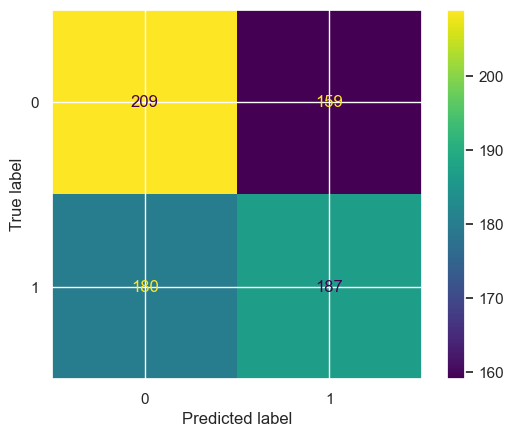

In [19]:
cm = confusion_matrix(pred, true, labels=dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=dt.classes_)
disp.plot()
plt.show()

### Linear Support Vector Classification
The Linear support vector classification, or SVC, is a Support Vector Machine (SVM) variant. Linear SVC aims to find a hyperplane and uses a hinge loss function, which penalizes misclassifications. We are using a Pipeline to run this model. With a 0.56 accuracy, the confusion matrix seems to be better distributed, resulting in the last over-fitting.

In [20]:
svc = make_pipeline(StandardScaler(),
                    LinearSVC(random_state=0, tol=1e-5))
svc.fit(X, Y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=0, tol=1e-05))])

In [21]:
pred2 = svc.predict(X2)
print(classification_report(true, pred2))

              precision    recall  f1-score   support

           0       0.60      0.53      0.56       389
           1       0.53      0.60      0.57       346

    accuracy                           0.56       735
   macro avg       0.57      0.57      0.56       735
weighted avg       0.57      0.56      0.56       735



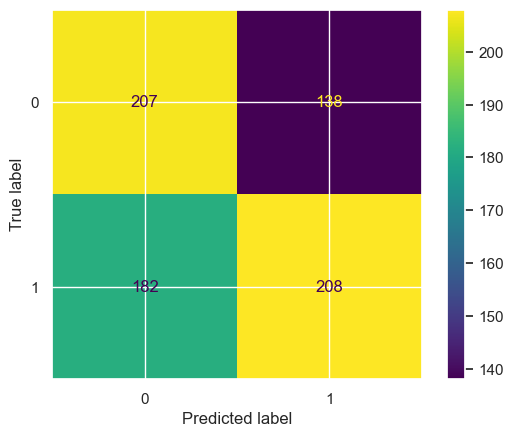

In [22]:
cm = confusion_matrix(pred2, true, labels=dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=dt.classes_)
disp.plot()
plt.show()

### Gaussian Naive Bayes
Based on the Bayes theorem, this classification assumes that features are conditionally independent given the class label. With a 0.56 accuracy, this model performs well with the improved label but not so well with the non-improved one.

In [23]:
pred3 = GaussianNB().fit(X, Y).predict(X2)
print(classification_report(true, pred3))

              precision    recall  f1-score   support

           0       0.60      0.49      0.54       389
           1       0.53      0.64      0.58       346

    accuracy                           0.56       735
   macro avg       0.56      0.56      0.56       735
weighted avg       0.57      0.56      0.56       735



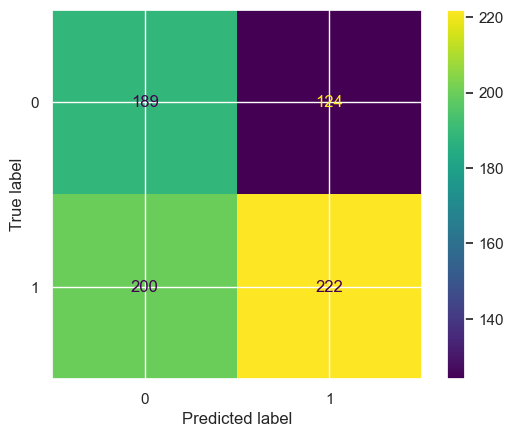

In [24]:
cm = confusion_matrix(pred3, true, labels=dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=dt.classes_)
disp.plot()
plt.show()

## Final project and conclusion
After observing all 3 results, we decided to use the SVC model to create our algorithm. Even though the accuracy isn't close to 100%, the model works and can be useful for the team staff when making decisions such as trading a player or resining one.

In [25]:
def player_will_improve(playerID, yearID):
    X = (train[['G_batting', 'age_of_player','years_of_play']]).to_numpy()
    Y = (train['improve']).to_numpy()
    svc = make_pipeline(StandardScaler(),
                    LinearSVC(random_state=0, tol=1e-5))
    svc.fit(X, Y)
    player = df[(df['playerID'] == playerID) & (df['yearID'].dt.year == yearID)]
    X2 = player[['G_batting', 'age_of_player', 'years_of_play']].to_numpy()
    prediction = svc.predict(X2)
    return 'yes' if prediction[0] == 1 else 'no'

In [26]:
test.head()

,playerID,yearID,teamID,G_batting,score,previous_year_score,birthYear,weight,age_of_player,years_of_play,teamID_encoded,improve
2898,mckinbi01,2021-01-01,MIL,40,1.425000,2.398810,1994-01-01,205.0,27.000684,2.759754,15,0
3684,reddijo01,2019-01-01,HOU,141,2.783688,2.604478,1987-01-01,197.0,32.000000,9.420945,10,1
2183,hundlni01,2014-01-01,BAL,50,2.320000,0.939394,1983-01-01,203.0,31.000684,5.494867,2,1
2697,mancitr01,2019-01-01,BAL,154,4.201299,2.834936,1992-01-01,230.0,27.000684,2.280630,2,1
4513,torreyo01,2013-01-01,COL,61,1.770492,2.107143,1978-01-01,200.0,35.000684,11.323751,8,0


In [27]:
player_will_improve('torreyo01', 2013)

'no'

In [28]:
player_will_improve('mancitr01', 2019)

'yes'